# Notebook for detecting multi-resolution clonal structures

This notebook reproduces the plots found in the accompanying paper, and loads parameters from a cached output file. Experiments can be re-produced using the scripts found in the above directory. This will also generate additional run-time plots using WandB logging callbacks.

In [12]:
import numpy as np
import pickle as pkl
import torch
import pandas as pd
import umap
import sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralBiclustering
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import style
from matplotlib import colors
import palettable
from palettable.colorbrewer.qualitative import Set1_6 as pallette

import TCGA
from WaveletVAE.src.WaveLSTM.models.base import WaveletBase


# Plotting set up
sns.set()
sns.set_palette(pallette.mpl_colors)
cmap = plt.cm.Blues
norm = colors.BoundaryNorm(np.arange(-0.5, 6.5, 1), cmap.N)

# %matplotlib notebook

# Get data

In [2]:
# Load data
cancer_types = ['THCA', 'BRCA', 'OV', 'GBM', 'HNSC']
dm = TCGA.data_modules.ascat.loaders.ASCATDataModule(batch_size=256, cancer_types=cancer_types,
                                                     chrom_as_channels=True,
                                                     sampler=False)

             chr   startpos     endpos  nMajor  nMinor       patient  \
sample                                                                 
TCGA-06-1084   1      61735   29007668       1       0  TCGA-06-1084   
TCGA-06-1084   1   29007729  200483106       2       1  TCGA-06-1084   
TCGA-06-1084   1  200483591  200709992       4       1  TCGA-06-1084   
TCGA-06-1084   1  200731556  205353468       2       1  TCGA-06-1084   
TCGA-06-1084   1  205353707  230843054       1       0  TCGA-06-1084   

             cancer_type sex                 barcodeTumour  \
sample                                                       
TCGA-06-1084         GBM  XY  TCGA-06-1084-01A-01D-0517-01   
TCGA-06-1084         GBM  XY  TCGA-06-1084-01A-01D-0517-01   
TCGA-06-1084         GBM  XY  TCGA-06-1084-01A-01D-0517-01   
TCGA-06-1084         GBM  XY  TCGA-06-1084-01A-01D-0517-01   
TCGA-06-1084         GBM  XY  TCGA-06-1084-01A-01D-0517-01   

                             barcodeNormal  ...  WGD      GI

Collect training, validation, and test features and labels

In [3]:
data, counts = [], []
for set_name, loader in zip(["Train", "Validation", "Test"], [dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader()]):
    print("\n" + set_name + " set \n" + "="*(len(set_name) + 4))
    
    # Combine batches
    features, labels = [], []
    for batch in iter(loader):
        features.append(batch["feature"])
        labels.append(batch["label"])
    data.append({"feature": torch.concat(features, 0).numpy().reshape((-1, 2, 23, 256)),
                 "label": torch.concat(labels, 0).numpy()}
               )
    
    # Report count of each clone 
    print(f"{data[-1]['feature'].shape[0]} samples composed of")
    count = []
    for lbl, cnt in zip(*np.unique(data[-1]['label'], return_counts=True)):
        print(f"{cancer_types[lbl]} with count {cnt}")
        count.append(cnt)
    counts.append(count)


Train set 
2416 samples composed of
THCA with count 794
BRCA with count 411
OV with count 397
GBM with count 414
HNSC with count 400

Validation set 
302 samples composed of
THCA with count 104
BRCA with count 46
OV with count 51
GBM with count 57
HNSC with count 44

Test set 
303 samples composed of
THCA with count 100
BRCA with count 45
OV with count 55
GBM with count 61
HNSC with count 42


In [4]:
for i, dset in zip(range(3), ["training", "validation", "test"]):
    print(f"Unique counts in {dset} set: \n {np.unique(data[i]['feature'])}")


Unique counts in training set: 
 [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  78.  79.  81.  82.  83.  84.  86.
  87.  89.  98. 109. 137.]
Unique counts in validation set: 
 [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  47.  48.  49.  50.  52.  54.  55.  61.  63.  64.
  68.  73.  85.  90. 103.]
Unique counts in test set: 
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 3

# Section 1: Visualisation of CNA data

Select which data set we want to visualise in this section of the notebook, and which chromosome and strand to highlight.

     

In [5]:
subset = 0           # 0=train set, 1=validation set, 2=test set
chromosome = 3       # 1,...,22
strand = 1           # 1=major or 2=minor

Define plotting functions

In [6]:
def plot_chromosomes(features, 
                     xlabel="Chromosomes",
                     ylabel="Cancer cell samples",
                     splits=None, 
                     figsize=(15,5)):

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.heatmap(features, 
                ax=ax, cmap=cmap, norm=norm, yticklabels=False,
               ) 
        
    # Vertical lines: indicating which chromosome we are zooming into in third plot
    for _chrom in range(1, 24):
        plt.axvline(x=(_chrom-1)*dm.W, color='k', alpha=0.25)
    # Horizontal lines: separating clones
    if splits is not None:
        for split in splits:
            plt.axhline(y=split, color='k', linestyle='-')
        ax.set_yticks((splits[1:] + splits[:-1])/2)
        ax.set_yticklabels(cancer_types)
        
    plt.ylabel(ylabel)
    # X-axis
    ax.set_xticks([ (_chrom+0.5) * dm.W for _chrom in range(23)])
    ax.set_xticklabels([_chrom for _chrom in range(1,24)], rotation=0)
    plt.xlabel(xlabel)
    # Manually specify colorbar labelling after it's been generated
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks(np.arange(-1, 6))
    colorbar.set_ticklabels([i for i in range(5)] + ["5+"])
    
def plot_chromosome(features, 
                    xlabel="Loci",
                    ylabel="Cancer cell samples",
                    splits=None, 
                    figsize=(8,5)):

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.heatmap(features, 
                ax=ax, cmap=cmap, norm=norm, yticklabels=False,
               ) 
        
    # Horizontal lines: separating clones
    if splits is not None:
        for split in splits:
            plt.axhline(y=split, color='k', linestyle='-')
        ax.set_yticks((splits[1:] + splits[:-1])/2)
        ax.set_yticklabels(cancer_types)
        
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # Manually specify colorbar labelling after it's been generated
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks(np.arange(-1, 6))
    colorbar.set_ticklabels([i for i in range(5)] + ["5+"])


## Plot chosen set, and zoom in on a selected chromosome and strand

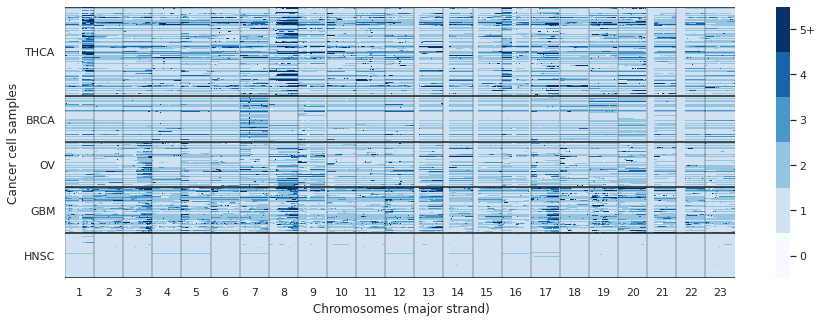

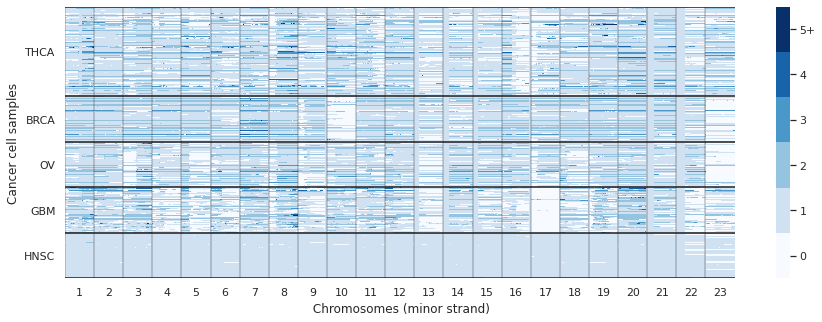

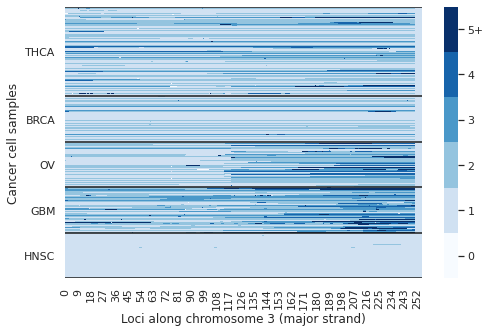

In [7]:
label_order = np.argsort(data[subset]["label"])
splits = np.insert(np.cumsum(counts[subset]), 0, 0)

# All chromosomes
for _strand in range(1,3):
    features = data[subset]["feature"][label_order, _strand-1, :, :].reshape((-1, 23*256))
    
    plot_chromosomes(features, 
                     splits=splits,
                     xlabel=f" Chromosomes ({'major' if _strand == 1 else 'minor'} strand)"
                    )
    plt.savefig(f"{'Major' if _strand == 1 else 'Minor'}Strand.png", dpi=500, format='png', transparent=False)
    
    
# Single chromosome
plot_chromosome(data[subset]["feature"][label_order, strand-1, chromosome-1, :],
                splits=splits,
                xlabel=f"Loci along chromosome {chromosome} ({'major' if strand == 1 else 'minor'} strand)")
plt.savefig(f"{'Major' if _strand == 1 else 'Minor'}Strand_Chr{chromosome}.png", dpi=500, format='png', transparent=False)


# Section 2: Model visualisations (test set)

Additional visualisations are also created at run-time with WandB logging, and can be viewed separately.


# Model visualisations

Additional visualisation are provided at run-time with WandB logging callbacks.

    Attentive autoencoder:
         "../logs/j8_nostack.pkl"


In [8]:
with open("../logs/desurv-output.pkl", 'rb') as file:
    meta_results = pkl.load(file)

# wave-LSTM outputs    
J = len(meta_results["resolution_embeddings"])
Mbar = torch.mean(meta_results["M"], axis=1).cpu().numpy()
M = meta_results["M"]
A = meta_results["attention"]

print(f"Available meta data keys")
for _key in meta_results.keys():
    print(f" * '{_key}'")
    
# wave-LSTM outputs    
# J = len(meta_results["resolution_embeddings"])
# lbls = meta_results["labels"].cpu().numpy()
# Mbar = torch.mean(meta_results["M"], axis=1).cpu().numpy()
# Mflat = torch.flatten(meta_results["M"], start_dim=1).cpu().numpy()
# A = meta_results["attention"]
# print(f"Available outputs: {[i for i in meta_results.keys()]}")

# # backwards compatability
# meta_results["masked_inputs"] = meta_results["scaled_masked_inputs"] 

Available meta data keys
 * 'scaled_masked_inputs'
 * 'scaled_masked_targets'
 * 'resolution_embeddings'
 * 'attention'
 * 'M'
 * 'ode_input'
 * 'labels'


## Section 2.1: Visualise Wave-LSTM encoder output

## Visualisation of self-attention

We can also visualise the learnt self-attention, allowing us to see which resolutions the model thought were predictive.

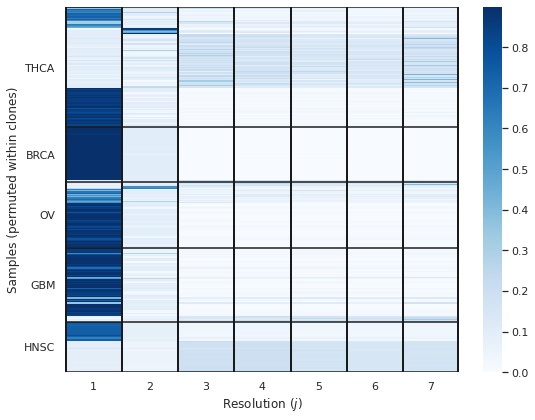

In [16]:
# Arguments
num_clusters = [4, 2, 3, 2, 2]                    # The number of sub-clusters to split each clone into    

Abar = torch.mean(A, dim=1).cpu().numpy()

# Nested ordering (by biclustering attention)
atn_order = []
for idx_cancer in range(5):
    lbl_idx = np.where(data[-1]["label"] == idx_cancer)[0]
    atn_clone = Abar[lbl_idx, :]
    clustering = sklearn.cluster.AgglomerativeClustering(n_clusters=np.min((num_clusters[idx_cancer], atn_clone.shape[0])))
    clustering.fit(atn_clone)
    permute_idx = np.argsort(clustering.labels_)
    atn_order.append(lbl_idx[permute_idx])
atn_order = np.concatenate(atn_order)

# Make permuted attention plot
fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.heatmap(Abar[atn_order, :], ax=ax, cmap='Blues', vmin=0, yticklabels=False)   # vmax=1
# Split clones
splits = np.insert(np.cumsum(counts[-1]), 0, 0)
for split in splits:
    plt.axhline(y=split, color='k', linestyle='-')
ax.set_yticks((splits[1:] + splits[:-1])/2)
ax.set_yticklabels(cancer_types)
ax.set_xticklabels([f"{j+1}" for j in range(J)], minor=False)    
# Split resolutions
for x_tick in [i for i in range(J)]:
    ax.vlines(x=x_tick+0.01, ymin=0, ymax=Abar.shape[0], linewidth=2, color='k')
ax.vlines(x=Abar.shape[1]-0.01, ymin=0, ymax=Abar.shape[0], linewidth=2, color='k')
# 
ax.set_xlabel("Resolution $(j)$")
ax.set_ylabel("Samples (permuted within clones)")    # permuted
plt.ylim((splits[-1], 0, ))
plt.tight_layout()
plt.savefig(f"figs/attention.png", dpi=500, format='png', transparent=False)

# Visualise Wave-LSTM encoder output

In [23]:
# First, just create instance of whatever reducer we want to use

reduce_method = "tSNE"         # tSNE or umap

if reduce_method.lower() == "umap":
    reducer = umap.UMAP()
elif reduce_method.lower() == "tsne":
    reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20)
else:
    raise NotImplementedError

# axis labels
latent1 = f"{reduce_method}-1"
latent2 = f"{reduce_method}-2"

### Resolution-embeddings (vs. source-separated inputs)

We visualise the learnt $h_j$, and compare how this differs from source-separated input $X_j$. 

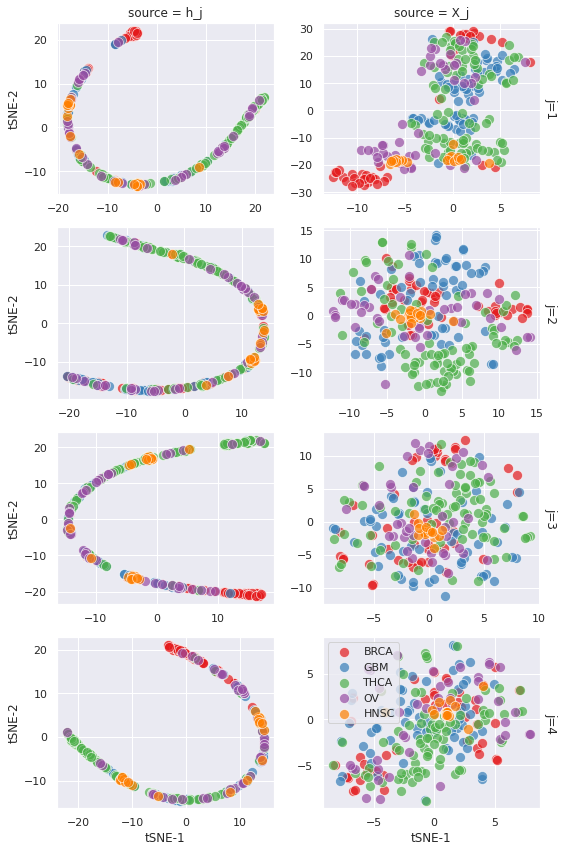

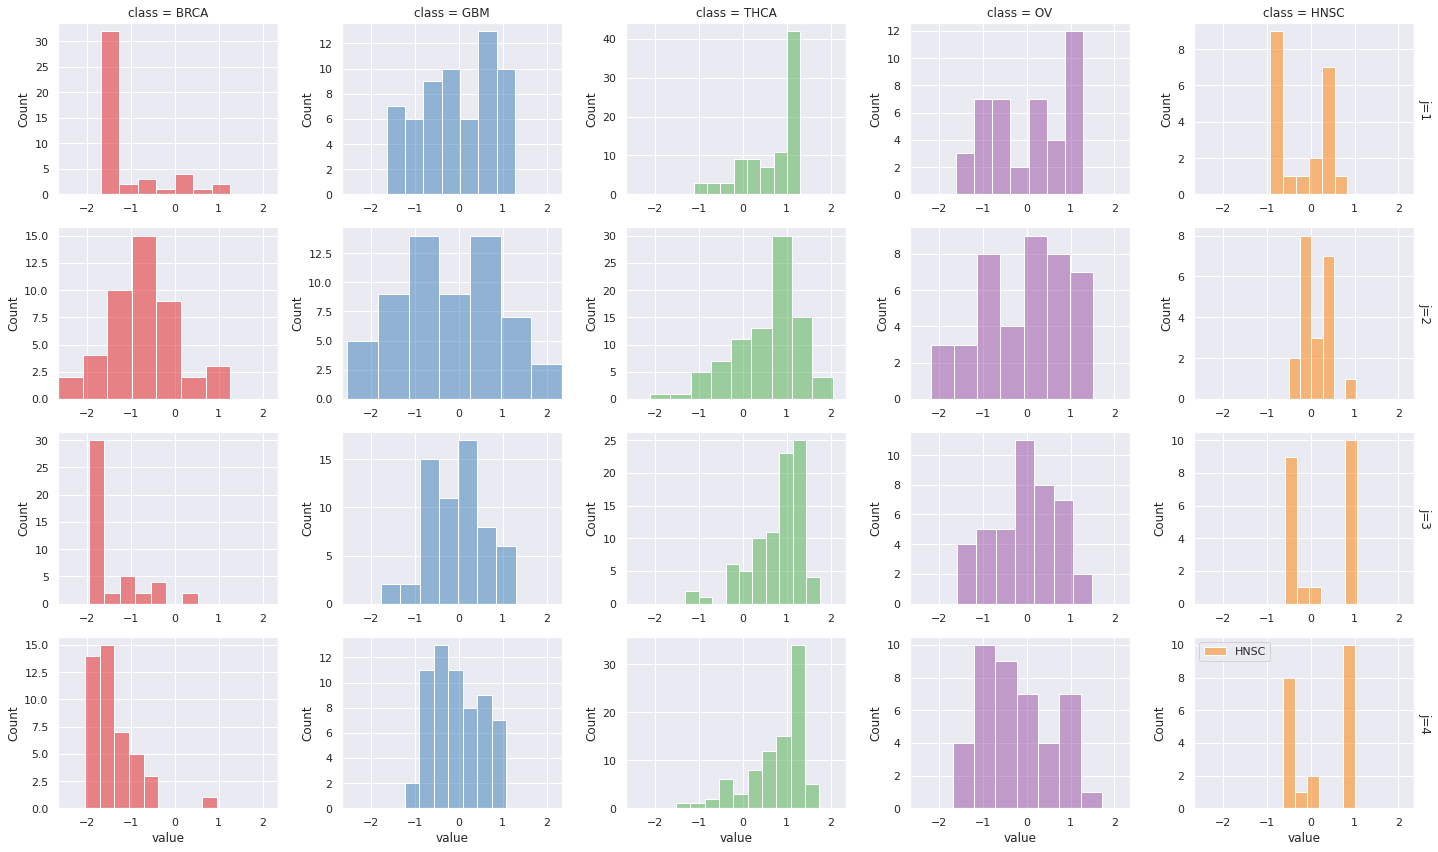

In [56]:
data = []
for j_res, j_name in zip([i for i in range(J)], [f"{j+1}" for j in range(J)]): 

    h_j = meta_results["resolution_embeddings"][j_res].cpu().numpy()
    x_j = meta_results["masked_inputs"][j_res].cpu().numpy()

    # Projection of scale embeddings, and source separated input
    for val, val_name in zip([h_j, x_j], ["h_j", "X_j"]):

        val = val.reshape((val.shape[0], -1))           # Reshape x_j to flatten channels
        val = StandardScaler().fit_transform(val)       # Scale before any transform
        
        embedding = reducer.fit_transform(val)
        for i in range(embedding.shape[0]):
            data.append([embedding[i, 0], embedding[i, 1], 
                         val_name,
                         j_name, cancer_types[lbls[i]],
                         val[i, :][0]
                        ])  

df_emb = pd.DataFrame(data, columns=[latent1, latent2, "source", "resolution", "class", "value"])
# print([_x.shape for _x in df_emb["value"]])

# Plot umap
g = sns.FacetGrid(df_emb, row="resolution", col="source", hue="class", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.scatterplot, latent1, latent2, alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="j={row_name}")
plt.legend()
plt.show()

# Plot histogram
df_hist = df_emb[df_emb["source"] == "h_j"]
g = sns.FacetGrid(df_hist, row="resolution", col="class", hue="class", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.histplot, 'value', alpha=0.5);
g.set(xlim=(df_hist["value"].min(), df_hist["value"].max()))
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="j={row_name}")
plt.legend()
plt.show()

We find that $h_j$ benefits from the information flow through the LSTM model. Embeddings are improved by

* the additional label/task information, leading to adaptive filtering.
* the ability of the LSTM model to pass information through the recurrent cell states. E.g. Whilst the orange class was separable at $X_{j=4}$, and subsequently not - within the resolution embeddings that information has been retained for $h_{j\geq4}$. Note, this behaviour can be controlled through reducing and increasing the capacity of the hidden states.


## Plot selective resolution embeddings (paper plot)

This is the paper plot version of the above section

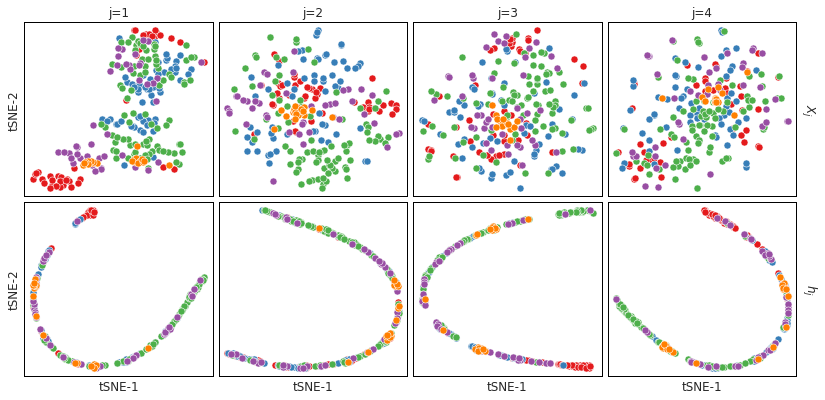

In [57]:
resolutions = [1,2,3,4]         # 1,2,3,...,J=4
sources = ["X_j", "h_j"]

df_fig2 = df_emb[df_emb["resolution"].isin([f"{i}" for i in resolutions])]
df_fig2 = df_fig2[df_fig2["source"].isin(sources)]
# df_fig2 = df_fig2[df_fig2["class"].isin([5, 6])]           # Zoom into subset of classes

g = sns.FacetGrid(df_fig2, col="resolution", row="source", hue="class", 
                  row_order=sources,
                  margin_titles=True, despine=False, height=3, aspect=1, sharex=False, sharey=False)
g.map(sns.scatterplot, f"{reduce_method}-1", f"{reduce_method}-2", alpha=1, s=50)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

g.set_titles(col_template="j={col_name}", row_template="${row_name}$")    # {row_name}
    

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label=f"{reduce_method}-1", clear_inner=True, )
g.set_ylabels(label=f"{reduce_method}-2", clear_inner=True, )

for ax in g.axes.flatten():  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    ax.set_facecolor((0, 0, 0, 0))

# Adjust margins
# plt.tight_layout()
g.figure.subplots_adjust(wspace=0.03, hspace=0.03)
# plt.gcf().set_size_inches(8, 3.5)
        
plt.savefig("resolution_embeddings.png", dpi=500, format='png', transparent=True)

## Visualisation of self-attention

We can also visualise the learnt self-attention, allowing us to see which resolutions the model thought were predictive.

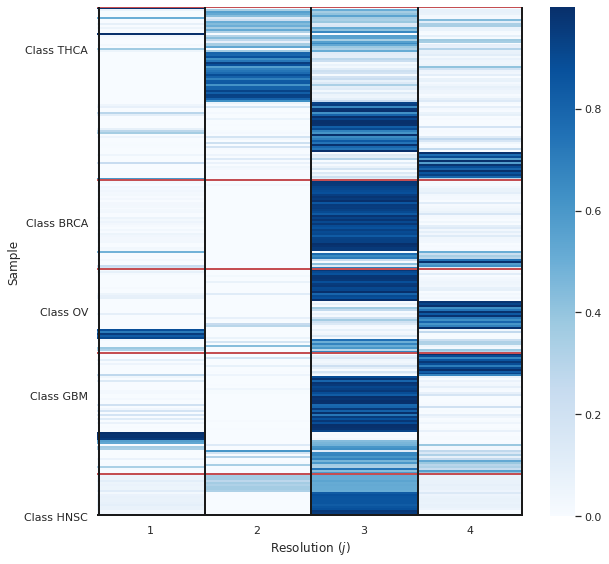

In [72]:
# Order samples by label
permute_idx = np.argsort(lbls)
ord_lbls = lbls[permute_idx]
ord_attention = A[permute_idx, :, :]

# average over attention hops:   [batch_size, num_multiscales]
ord_attention = torch.mean(ord_attention, dim=1).cpu().numpy()  

# Nested ordering (by biclustering attention)
attention_new = np.zeros_like(ord_attention)
for _lbl in np.unique(ord_lbls):
    lbl_idx = np.where(ord_lbls == _lbl)[0]
    atn_cls = ord_attention[lbl_idx, :]
    biclustering = SpectralBiclustering(n_clusters=(4, 1), method="log", random_state=0)
    biclustering.fit(atn_cls)
    atn_cls = atn_cls[np.argsort(biclustering.row_labels_)]
    attention_new[lbl_idx, :]  = atn_cls#[:, np.argsort(biclustering.column_labels_)]
attention = attention_new


# Plot
fig, ax = plt.subplots(1, 1, figsize=(9,8))
sns.heatmap(attention, ax=ax, cmap='Blues', vmin=0, yticklabels=False)   # vmax=1

# Add horizontal lines
y_tick_locations = [np.where(ord_lbls == _lbl)[0][0] for _lbl in np.unique(ord_lbls)]
for y_tick in y_tick_locations:
    ax.hlines(y=y_tick+0.1, xmin=0, xmax=20, linewidth=2, color='r')
ax.hlines(y=attention.shape[0]-0.1, xmin=0, xmax=20, linewidth=2, color='k')

# Add vertical lines
for x_tick in [i for i in range(J)]:
    ax.vlines(x=x_tick+0.01, ymin=0, ymax=attention.shape[0], linewidth=2, color='k')
ax.vlines(x=attention.shape[1]-0.01, ymin=0, ymax=attention.shape[0], linewidth=2, color='k')

    
ax.set_yticks([yi+attention.shape[0]/12 for yi in y_tick_locations])
# ax.set_yticks([], minor=True)
# ax.yaxis.grid(True, which='major', lw=1, ls='-', color='k')
ax.set_yticklabels([f"Class {cancer_types[i]}" for i in np.unique(ord_lbls)])
ax.set_xticklabels([f"{j+1}" for j in range(J)], minor=False)

ax.set_xlabel("Resolution $(j)$")
ax.set_ylabel("Sample")    # permuted

plt.tight_layout()
plt.savefig("attention.png", dpi=500, format='png', transparent=True)

## Visualisation of the multi-resolution embedding

We can visualise the embedding tensor $M$ by either flattening, or taking the average across hops. For this example $r_{\text{hops}}=1$, and so they are equivalent.

      tSNE-1     tSNE-2 source class     value
0  16.989977 -12.861783  Mflat  BRCA -3.034507
1  13.818105 -14.494665  Mflat  BRCA -2.877659
2  14.069916 -14.164604  Mflat  BRCA -2.893588
3   2.273041 -16.316605  Mflat   GBM -1.672372
4  15.961538 -13.276181  Mflat  BRCA -2.981489


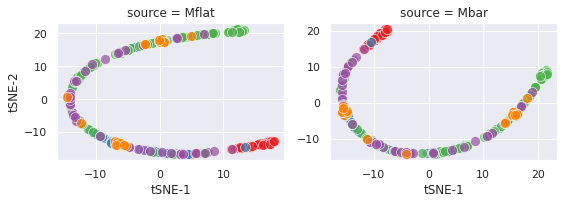

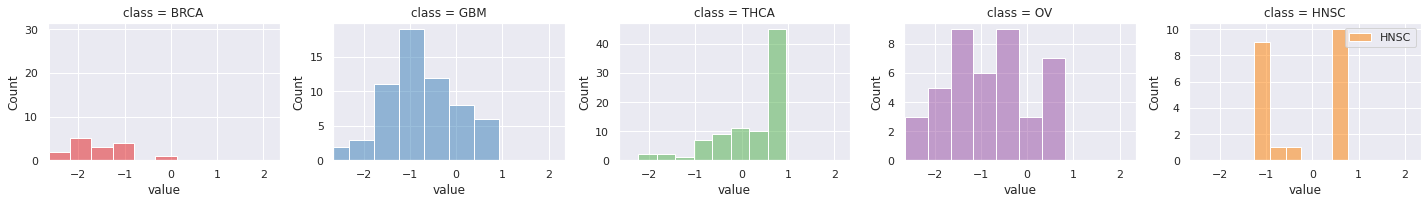

In [61]:
data = []

for Mvar, Mname in zip([Mflat, Mbar], ["Mflat", "Mbar"]):

    embedding = reducer.fit_transform(Mvar.reshape((Mvar.shape[0], -1)))

    for i in range(embedding.shape[0]):
        data.append([embedding[i, 0], embedding[i, 1], 
                     Mname,
                     cancer_types[lbls[i]],
                     Mvar[i, :][0]
                    ])  

df_mres_emb = pd.DataFrame(data, columns=[latent1, latent2, "source", "class", "value"])
print(df_mres_emb.head())

# Plot
g = sns.FacetGrid(df_mres_emb, col="source", hue="class", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.scatterplot, latent1, latent2, alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)


# Plot histogram
df_mres_emb = df_mres_emb[df_mres_emb["source"]=="Mflat"]
g = sns.FacetGrid(df_mres_emb, col="class", hue="class", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.histplot, 'value', alpha=0.5);
g.set(xlim=(df_hist["value"].min(), df_hist["value"].max()))
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="j={row_name}")
plt.legend()
plt.show()